In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
import skimage

import tensorflow as tf
from tensorflow import keras

In [3]:
import pandas as pd

df = pd.read_csv('IMDB.csv', sep = ',')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [6]:
# Encode labels: each label is an integer value of either 0 or 1, 
#where 0 is a negative review, and 1 is a positive review.

from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
print(df.shape)

(50000, 2)


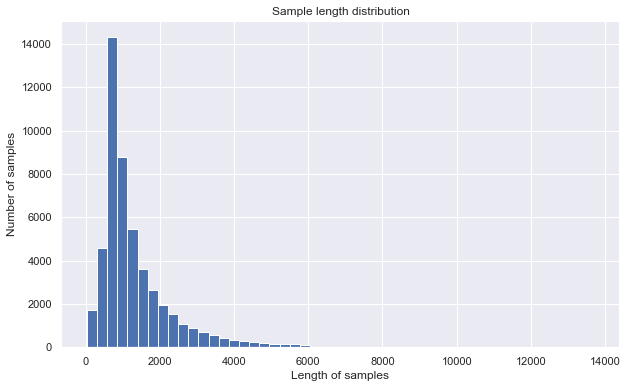

In [8]:
# Now, let's see the average number of words per sample
plt.figure(figsize=(10, 6))

# Here 50 is bin size
plt.hist([len(sample) for sample in list(df['review'])], 50)

plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()



tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators. counting the occurrences of tokens in each document. normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents. In this scheme, features and samples are defined as follows:

each individual token occurrence frequency (normalized or not) is treated as a feature. the vector of all the token frequencies for a given document is considered a multivariate sample. A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

Now use the CountVectorizer provided by the scikit-learn library to vectorize sentences. It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a feature vector of the count of the words:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

#CountVectorizer()- Convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(list(df['review']))

all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), 
                                                         reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

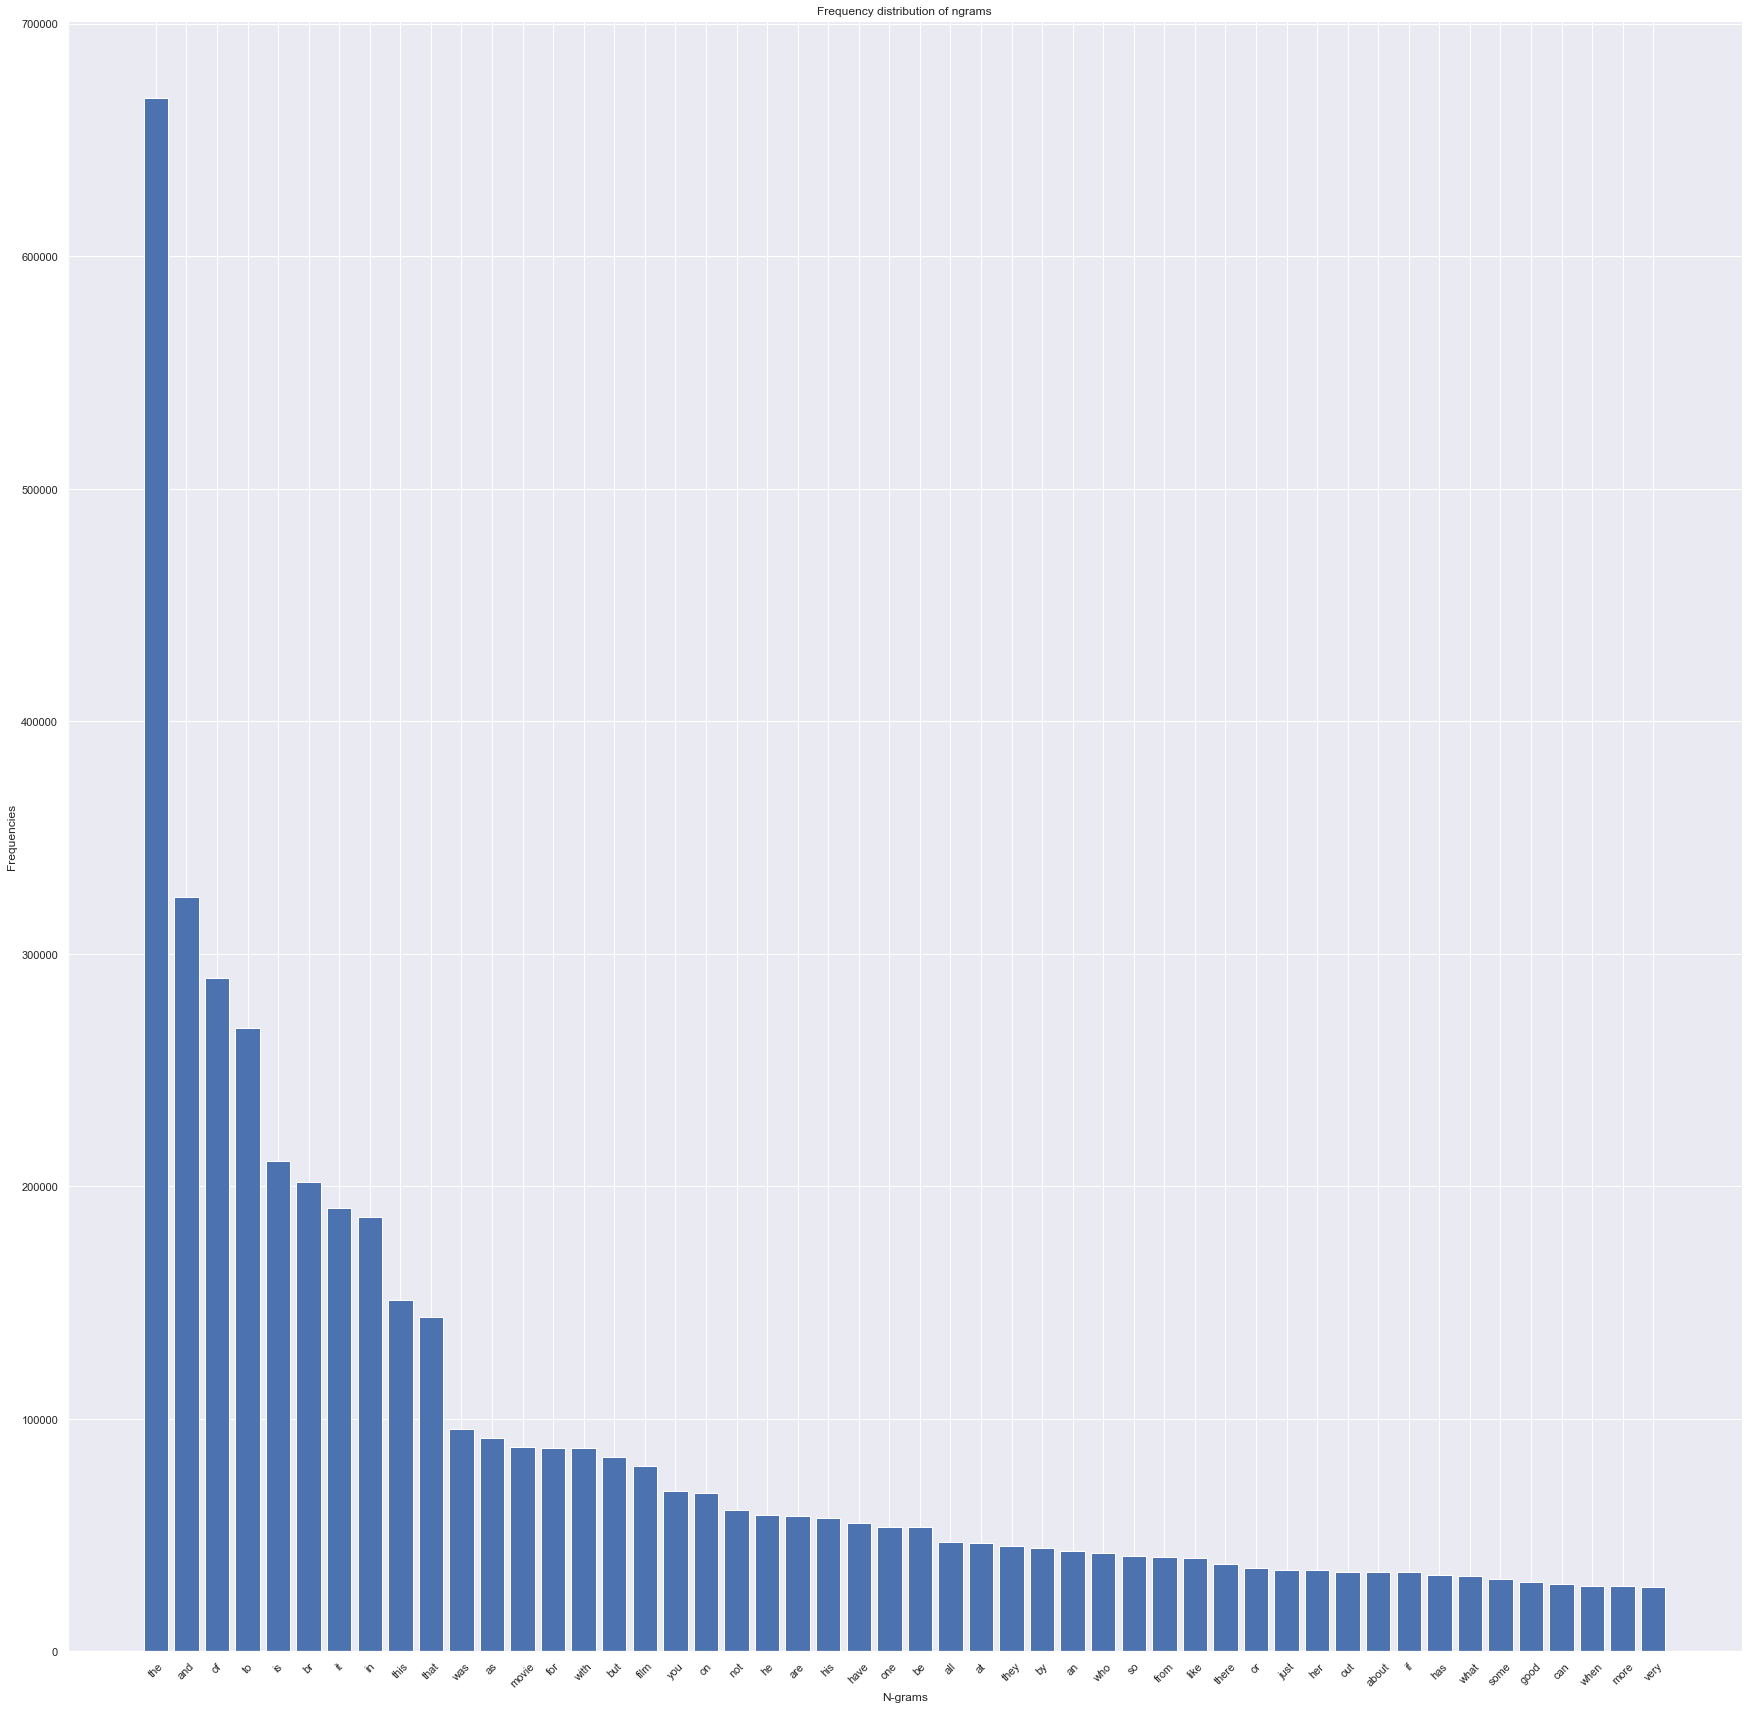

In [10]:
# Let's now plot a frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts
# Vectorize the data
vect_data = ngram_vectorize(df['review'], df['sentiment'])

In [12]:
vect_data.shape

(50000, 20000)

In [13]:
tfidf = TfidfVectorizer()
tr_texts = tfidf.fit_transform(df['review'])
tr_texts.shape

(50000, 101895)

In [15]:
tr_texts

<50000x101895 sparse matrix of type '<class 'numpy.float64'>'
	with 6826529 stored elements in Compressed Sparse Row format>

In [16]:
# Split data to label (y) and features (X)

# There are 50000 datapoints with 20000 feature each.
X = vect_data.toarray()
print('The shape of the features of the dataset is: ',X.shape)

# there are 50000 labels that are under sentiment column.
y = (np.array(df['sentiment']))
print('The shape of the labels of the dataset is: ',y.shape)

The shape of the features of the dataset is:  (50000, 20000)
The shape of the labels of the dataset is:  (50000,)


In [17]:
from sklearn.model_selection import train_test_split

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
print("Train features shape: {0}, \nTest features shape: {1}".format(X_train.shape, 
                                                                   X_test.shape))
print("Train label shape: {0}, \nTest label shape: {1}".format(y_train.shape, 
                                                                   y_test.shape))

#The testing label is 10000 and the training label in 40000 and each has 20000 features 
#related to it.

Train features shape: (40000, 20000), 
Test features shape: (10000, 20000)
Train label shape: (40000,), 
Test label shape: (10000,)


In [18]:
# For the validation purpose we are further dividing the feature training dataset into 
#validation and training dataset.
x_val = X_train[:10000]
train_X = X_train[10000:]

In [19]:
# For the validation purpose we are further dividing the label training dataset into 
#validation and training dataset.
y_val = y_train[:10000]
train_y = y_train[10000:]

In [20]:
from keras import models
from keras import layers
from keras.utils import to_categorical

input_shape_of_feature = X_train.shape[1:]
print(input_shape_of_feature)

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape= input_shape_of_feature))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

(20000,)


Using TensorFlow backend.


In [21]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# By using the fit method we are traing the model using train_X, train_y and validating it 
# on x_val, y_val which will give us 'val_loss', 'val_acc', 'training_loss', 'training_acc'
model_history = model.fit(train_X, train_y, epochs=20, batch_size=512,
validation_data=(x_val, y_val))

Train on 30000 samples, validate on 10000 samples
Epoch 1/20
30000/30000 [==============================] - 3s 107us/step - loss: 0.6050 - acc: 0.8440 - val_loss: 0.5089 - val_acc: 0.8767
Epoch 2/20
30000/30000 [==============================] - 2s 82us/step - loss: 0.4195 - acc: 0.9006 - val_loss: 0.3440 - val_acc: 0.9057
Epoch 3/20
30000/30000 [==============================] - 3s 86us/step - loss: 0.2789 - acc: 0.9216 - val_loss: 0.2489 - val_acc: 0.9180
Epoch 4/20
30000/30000 [==============================] - 3s 101us/step - loss: 0.2011 - acc: 0.9345 - val_loss: 0.2058 - val_acc: 0.9249
Epoch 5/20
30000/30000 [==============================] - 3s 102us/step - loss: 0.1592 - acc: 0.9447 - val_loss: 0.1883 - val_acc: 0.9294
Epoch 6/20
30000/30000 [==============================] - 2s 76us/step - loss: 0.1329 - acc: 0.9532 - val_loss: 0.1794 - val_acc: 0.9306
Epoch 7/20
30000/30000 [==============================] - 2s 72us/step - loss: 0.1145 - acc: 0.9594 - val_loss: 0.1768 - val_

In [22]:
model_history_dict = model_history.history
model_history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

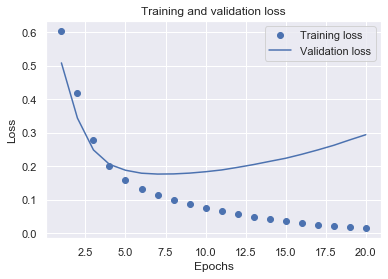

In [24]:
import matplotlib.pyplot as plt

#model_history_dict = model_history.history
training_loss_values = model_history_dict['loss']
val_loss_values = model_history_dict['val_loss']

epochs = range(1, len(model_history_dict['acc']) + 1)

plt.plot(epochs, training_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

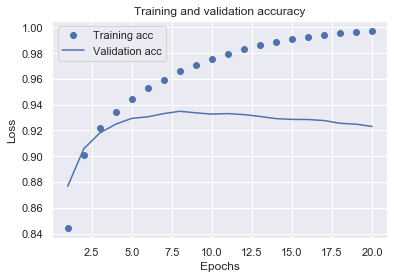

In [25]:
acc_values = model_history_dict['acc']
val_acc_values = model_history_dict['val_acc']

plt.plot(epochs, model_history_dict['acc'], 'bo', label='Training acc')
plt.plot(epochs, model_history_dict['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

There is overfitting after the second epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set. In this case, to prevent overfitting, you could stop training after three epochs.

In [26]:
from keras import models
from keras import layers
from keras.utils import to_categorical

input_shape = X_train.shape[1:]

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape= input_shape))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])

model.fit(X_train, y_train, epochs=4,batch_size=512)

results = model.evaluate(X_test, y_test)

Epoch 1/4
40000/40000 [==============================] - 3s 80us/step - loss: 0.5769 - accuracy: 0.8677
Epoch 2/4
40000/40000 [==============================] - 3s 77us/step - loss: 0.3385 - accuracy: 0.9110
Epoch 3/4
40000/40000 [==============================] - 4s 90us/step - loss: 0.2142 - accuracy: 0.9284
Epoch 4/4
10000/10000 [==============================] - 1s 69us/step


In [27]:
results

[0.18441611107587813, 0.9297999739646912]

In [30]:
# Using different optimizer and loss for comparision.

from keras import models
from keras import layers
from keras.utils import to_categorical

input_shape = X_train.shape[1:]

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape= input_shape))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd',loss='mse', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=4,batch_size=512)

results = model.evaluate(X_test, y_test)

Epoch 1/4
40000/40000 [==============================] - 3s 70us/step - loss: 0.2500 - accuracy: 0.4963
Epoch 2/4
40000/40000 [==============================] - 2s 62us/step - loss: 0.2500 - accuracy: 0.5098
Epoch 3/4
40000/40000 [==============================] - 3s 63us/step - loss: 0.2500 - accuracy: 0.5210
Epoch 4/4
10000/10000 [==============================] - 1s 68us/step


In [31]:
results

[0.24996041910648345, 0.5285999774932861]